# PyESAPI: General Example
*By Michael.Folkerts@varian.com*

In [2]:
import pyesapi
from matplotlib import pyplot as plt
import numpy as np
from time import time
import atexit
#load app only once
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')  # script name is used for logging
# setup clean exit
atexit.register(app.Dispose);

In [12]:
import pandas as pd
print(
    "Patients:\n",
    pd.DataFrame(
        [(p.Id, p.LastName, p.FirstName) for p in app.PatientSummaries], # pythonnet treats collections as iterables
        columns = ['Id', 'Last Name', 'First Name']
    )
)

Patients:
                      Id   Last Name      First Name
0             ref brain  Brain Case          Helios
1      connie breast pt      Connie  Breast patient
2                191001   Lung Case          Helios
3         TestUpperBody       Pizza       Blueberry
4  HeartDVHErrorV35Gycc       Error        Clinical


In [13]:
patient = app.OpenPatientById('TestUpperBody')

ApplicationException: Only one patient can be open at a time. Close the previous one.
   at VMS.TPS.Common.Model.API.Application.ThrowIfPatientAlreadyOpen()
   at VMS.TPS.Common.Model.API.Application.OpenPatientById(String id)

In [14]:
for plan in patient.CoursesLot(0).PlanSetups:
    print(plan.Id)

IMRT


In [39]:
# shortcut for patient.Courses.ElementAt(0).PlanSetups.FirstOrDefault(lambda x: x.Id == 'IMRT' )
plan = patient.CoursesLot(0).PlanSetupsLot('IMRT')

# normal indexing works too
structures = patient.StructureSetsLot()[0].StructuresLot()

# lot.Select takes a function and returns a lot
lungs = structures.Select(lambda s: 'Lun' in s.Id)
print("Lungs:",[(f.Id,f.Volume) for f in lungs])

body1 = patient.StructureSetsLot()[0].StructuresLot('BODY')
body = structures['BODY']  # another shortcut for FirstOrDefault on Id field
assert body == body1  # same object

voxels = plan.Dose.np_voxel_locations()  # a pyesapi extension!
print(voxels[0,0,0])
#voxels = plan.StructureSet.Image.np_voxel_locations()  # a pyesapi extension!

Lungs: [('R Lung', 939.143210944022), ('L Lung', 760.367520077639), ('Total Lung', 1705.6240758698507)]
[  440.3498849  -177.364724  -1479.56     ]


In [11]:
# let's grab some structure masks using pysapi extension method
# this is actually a little slow, but worth the wait... (better impemented in c++ and added to ESAPI)
structures_of_interest = ['PTV 8100','bladder','rectum','body']
masks = {}
tic = time()
for s in structures:
    if s.Id in structures_of_interest:
        print("Creating mask for {} at Dose grid resolution...            ".format(s.Id),end='\r')
        masks[s.Id] = plan.Dose.np_structure_mask(s)  # pysapi extension!
        #print("Creating mask for {} at CT Image resolution...            ".format(s.Id),end='\r')
        #masks[s.Id] = plan.StructureSet.Image.np_structure_mask(s)  # pysapi extension!
print("Creating structure masks took {:0.2f} s                   ".format(time()-tic))

tic = time()
dose = plan.Dose.np_array_like()  # pysapi extension! (Dose at Dose grid resolution, default)
#dose = plan.Dose.np_array_like(plan.StructureSet.Image)  # pysapi extension! (Dose at CT Image resolution)
print("Extracting dose took {:0.2f} s".format(time()-tic))

Creating structure masks took 3.19 s                             
Extracting dose took 0.05 s


In [12]:
# run some verification based on Structure.IsPointInsideSegment(VVector) ...
# this is very slow!
for sId in structures_of_interest:
    print("Verifying {} mask...".format(sId))
    pysapi.validate_structure_mask(structures[sId],masks[sId],voxels)

Verifying PTV 8100 mask...
mask error (%): 0.054558680892337535


AssertionError: Masking error greater than 0.05 %

(132, 81, 111)


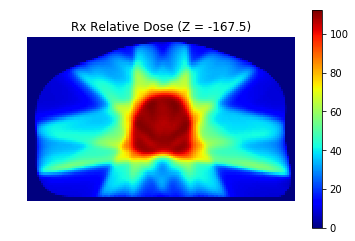

In [13]:
# plot a dose slice ...
assert plan.DoseValuePresentation == pysapi.DoseValuePresentation.Relative, "dose not in relative units"
slice_idx = 39
slice_z_mm = voxels[0,0,slice_idx][2]  # a 3D array of 3D points of locations for each voxel
print(dose.shape)
plt.imshow(dose[:,:,slice_idx].T,interpolation=None,cmap='jet')  # indexed as [x,y,z], transpose needed for imshow
plt.axis('off')
plt.colorbar()
plt.title("Rx Relative Dose (Z = {:.1f})".format(slice_z_mm))
plt.show()

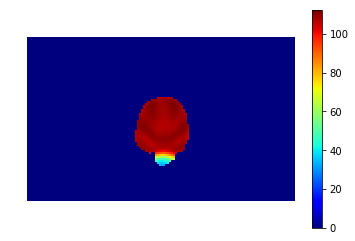

In [14]:
# plot masked dose ...
all_masks = np.zeros_like(masks['body'])
for k,mask in masks.items():
    if k == 'body':
        continue
    all_masks = np.logical_or(all_masks,mask)

plt.imshow((dose*all_masks)[:,:,slice_idx].T,interpolation=None,cmap='jet')  # mask is indexed same as dose grid
plt.axis('off')
plt.colorbar()
plt.title("")
plt.show()

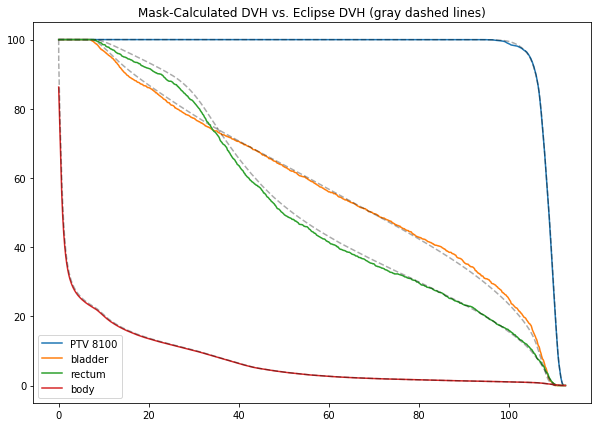

In [15]:
# let's compute some DVH "by hand" and compare to Eclipse

plt.figure(figsize=(10,7))
for sId in ['PTV 8100','bladder','rectum','body']:
    mask_idx = np.where(masks[sId])
    tot_vox = np.ones_like(dose)[mask_idx].sum()
    hist,bins = np.histogram(dose[mask_idx].flatten(),bins=1000,range=(0,dose.max()))

    plt.plot(bins[:-1],100.-hist.cumsum()*100.0/tot_vox,label=sId)
    dvh = plan.GetDVHCumulativeData(
        structures[sId],
        pysapi.DoseValuePresentation.Relative,
        pysapi.VolumePresentation.Relative,
        .01
    )
    pts = np.array([[p.DoseValue.Dose,p.Volume] for p in dvh.CurveData])
    plt.plot(pts[:,0],pts[:,1],'k--',alpha=.33)

plt.legend(loc=0)
plt.title("Mask-Calculated DVH vs. Eclipse DVH (gray dashed lines)")
plt.show()

In [16]:
# to exit cleanly when done...
app.ClosePatient()